# Introduction
Following the EDA analysis (*where we failed to build the profile of the suitable Shooting Guard player to buy, by conducting a naive method of sorting the dataset by a master feature (`AST_PCT`) and taking the upper segment of*), we now set our way for a more advanced tehcnique.

**Scope**: Segment the 'plays' dataset and capture the underlying patterns which may lead us to the best SG player, by reataining at the same time most of the crucial statistics (group_1) at high levels.

In this section, we tried **K-Means** and **Gaussian Mixture** Models clustering algorithms in an effort to effectively segment data and capture the underlying patterns. Indeed, we resulted in a powerful segment of plays (`cluster_3`) where most of the features are in high level. This achievement took place by taking into account all the significant variables and not just one, as in the case of the EDA.

In [35]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from kneed import KneeLocator
pd.set_option('display.max_columns', None)
%load_ext blackcellmagic
%config InlineBackend.figure_format = 'retina'

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


# 1. Read in data

In [36]:
# read in the data
plays_df = pd.read_csv('../notebooks/plays_17_18_19_pre_proc_train.csv',
                       converters={'GAME_ID': lambda x: str(x)})
plays_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
0,0021700002,2017-10-17,1610612745,HOU,Houston,2772,Trevor Ariza,Trevor,2,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063
1,0021700002,2017-10-17,1610612745,HOU,Houston,201583,Ryan Anderson,Ryan,2,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064
2,0021700002,2017-10-17,1610612745,HOU,Houston,203991,Clint Capela,Clint,3,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092
3,0021700002,2017-10-17,1610612745,HOU,Houston,201935,James Harden,James,1,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134
4,0021700002,2017-10-17,1610612745,HOU,Houston,101108,Chris Paul,Chris,1,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068


In [37]:
plays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62893 entries, 0 to 62892
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GAME_ID            62893 non-null  object 
 1   GAME_DATE          62893 non-null  object 
 2   TEAM_ID            62893 non-null  int64  
 3   TEAM_ABBREVIATION  62893 non-null  object 
 4   TEAM_CITY          62893 non-null  object 
 5   PLAYER_ID          62893 non-null  int64  
 6   PLAYER_NAME        62893 non-null  object 
 7   NICKNAME           62893 non-null  object 
 8   START_POSITION     62893 non-null  int64  
 9   MIN                62893 non-null  int64  
 10  OFF_RATING         62893 non-null  float64
 11  DEF_RATING         62893 non-null  float64
 12  AST_PCT            62893 non-null  float64
 13  AST_TOV            62893 non-null  float64
 14  AST_RATIO          62893 non-null  float64
 15  OREB_PCT           62893 non-null  float64
 16  DREB_PCT           628

In [38]:
# final features
features = [
    col
    for col in plays_df.columns
    if col
    not in (
        "GAME_ID",
        "TEAM_ID",
        "TEAM_ABBREVIATION",
        "TEAM_CITY",
        "PLAYER_ID",
        "PLAYER_NAME",
        "NICKNAME",
        "GAME_DATE"
    )
]

In [39]:
# classify features by domain importance
group_1 = ['OFF_RATING', 'AST_PCT', 'AST_TOV',
           'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'POSS']
group_2 = ['MIN', 'AST_RATIO', 'DREB_PCT']
group_3 = ['OREB_PCT', 'REB_PCT', 'USG_PCT', 'PACE', 'PACE_PER40', 'PIE']
group_4 = ['START_POSITION']
group_5 = ['DEF_RATING']

In [40]:
data = plays_df[features].copy()
data.head()

,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
0,2,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063
1,2,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064
2,3,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092
3,1,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134
4,1,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068


# 2. Data Processing
## 2.1 Standardization

In [41]:
data_stnd = data.copy()
data_stnd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62893 entries, 0 to 62892
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   START_POSITION  62893 non-null  int64  
 1   MIN             62893 non-null  int64  
 2   OFF_RATING      62893 non-null  float64
 3   DEF_RATING      62893 non-null  float64
 4   AST_PCT         62893 non-null  float64
 5   AST_TOV         62893 non-null  float64
 6   AST_RATIO       62893 non-null  float64
 7   OREB_PCT        62893 non-null  float64
 8   DREB_PCT        62893 non-null  float64
 9   REB_PCT         62893 non-null  float64
 10  TM_TOV_PCT      62893 non-null  float64
 11  EFG_PCT         62893 non-null  float64
 12  TS_PCT          62893 non-null  float64
 13  USG_PCT         62893 non-null  float64
 14  PACE            62893 non-null  float64
 15  PACE_PER40      62893 non-null  float64
 16  POSS            62893 non-null  int64  
 17  PIE             62893 non-null 

In [42]:
scaler = MinMaxScaler()
data_stnd = scaler.fit_transform(data_stnd)

In [43]:
data_stnd

array([[0.66666667, 0.67432836, 0.318     , ..., 0.00707967, 0.66115702,
        0.43307143],
       [0.66666667, 0.5961194 , 0.364     , ..., 0.00720795, 0.60330579,
        0.43314286],
       [1.        , 0.32537313, 0.27171429, ..., 0.00742786, 0.33884298,
        0.43514286],
       ...,
       [0.        , 0.22059701, 0.20114286, ..., 0.00743952, 0.2231405 ,
        0.42578571],
       [0.        , 0.14089552, 0.26885714, ..., 0.00698887, 0.14049587,
        0.43207143],
       [0.        , 0.0358209 , 0.5       , ..., 0.006664  , 0.03305785,
        0.38778571]])

## 2.2 PCA

In [44]:
pca = PCA()
pca.fit(data_stnd)
pca.explained_variance_ratio_

array([4.24496750e-01, 1.86060878e-01, 1.31704031e-01, 8.64975519e-02,
       4.63907573e-02, 4.05737997e-02, 2.62069032e-02, 1.44743066e-02,
       1.17468056e-02, 9.39473597e-03, 9.25317630e-03, 6.20648579e-03,
       4.82852015e-03, 9.51640216e-04, 6.35694378e-04, 2.94027966e-04,
       2.83935845e-04, 1.38365079e-13])

<Figure size 720x576 with 0 Axes>

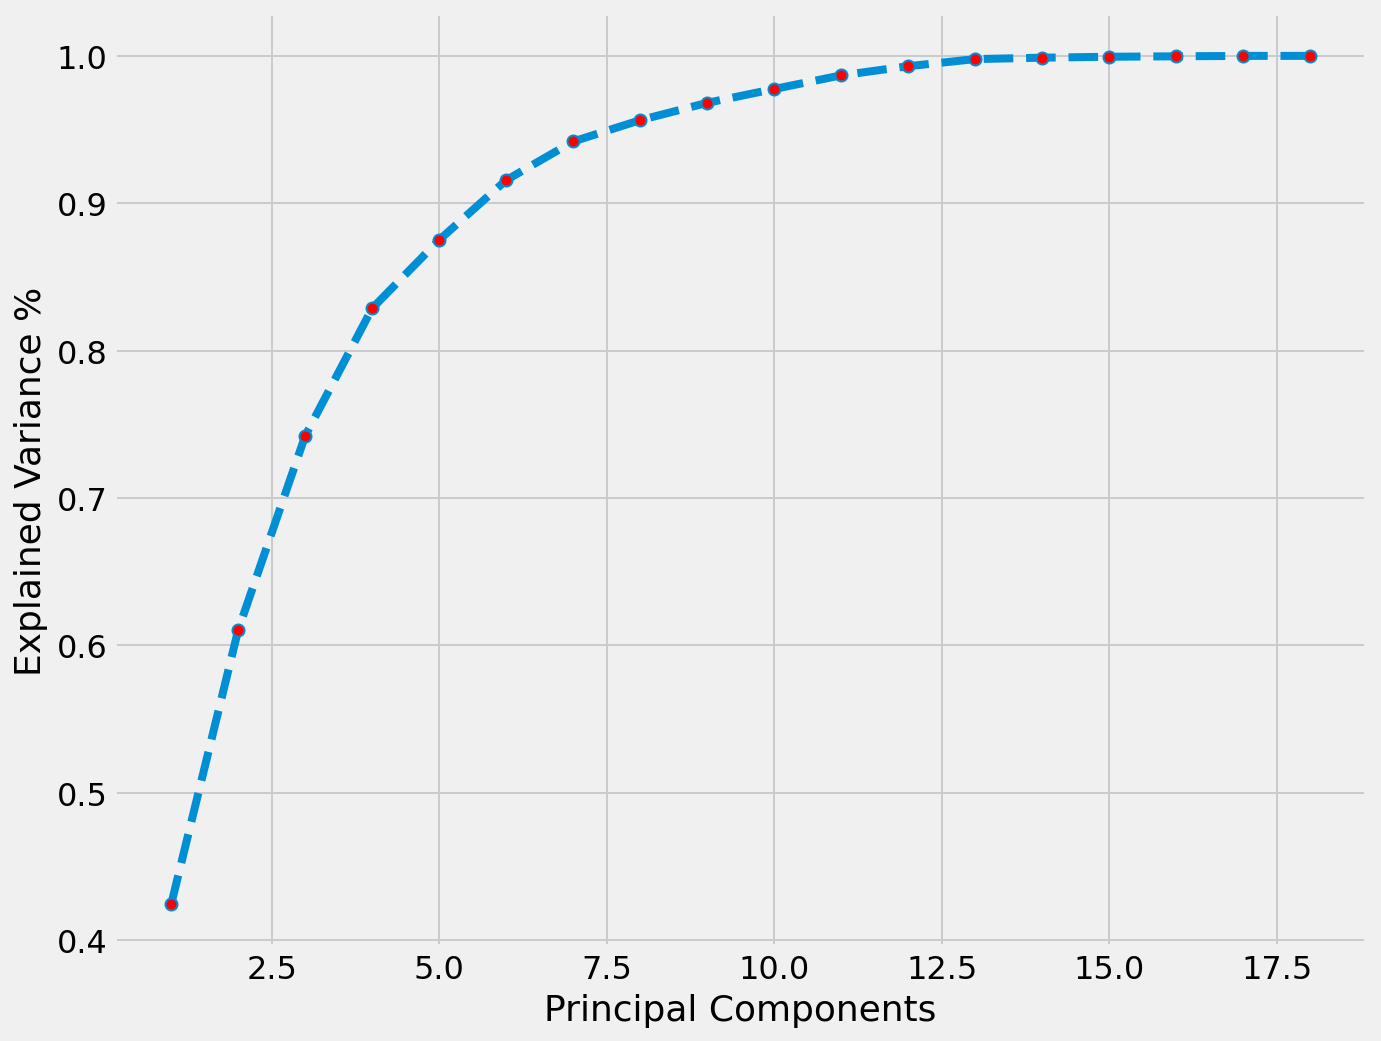

In [45]:
# Visualize the variance to locate the # of principal components
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(10, 8))
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, 19), pca.explained_variance_ratio_.cumsum(), markerfacecolor='red', marker='o', linestyle='--')
    plt.xlabel('Principal Components', fontsize=18)
    plt.ylabel('Explained Variance %', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

In this step we opt for the 4 components solution, as it explain at least 80% of the population's variance.

In [46]:
pca = PCA(n_components = 4)
pca.fit(data_stnd)
pca_scores = pca.transform(data_stnd)

# 3. Clustering
## 3.1 K-Means
We start by utilizing the K-Means, as it is a popular centroid-based clusering algorithm.

In [47]:
plays_km_df = plays_df.copy()

In [48]:
max_clusters = 11
wcss = list()

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, init='random', random_state=1)
    kmeans.fit(pca_scores)
    wcss.append(kmeans.inertia_)

In [49]:
wcss

[18512.17103169024,
 10945.057770158004,
 8639.760851899013,
 6962.465321433958,
 6213.819794588243,
 5572.248266273254,
 5074.992737326949,
 4697.03557778265,
 4379.3653997722295,
 4114.528520646868]

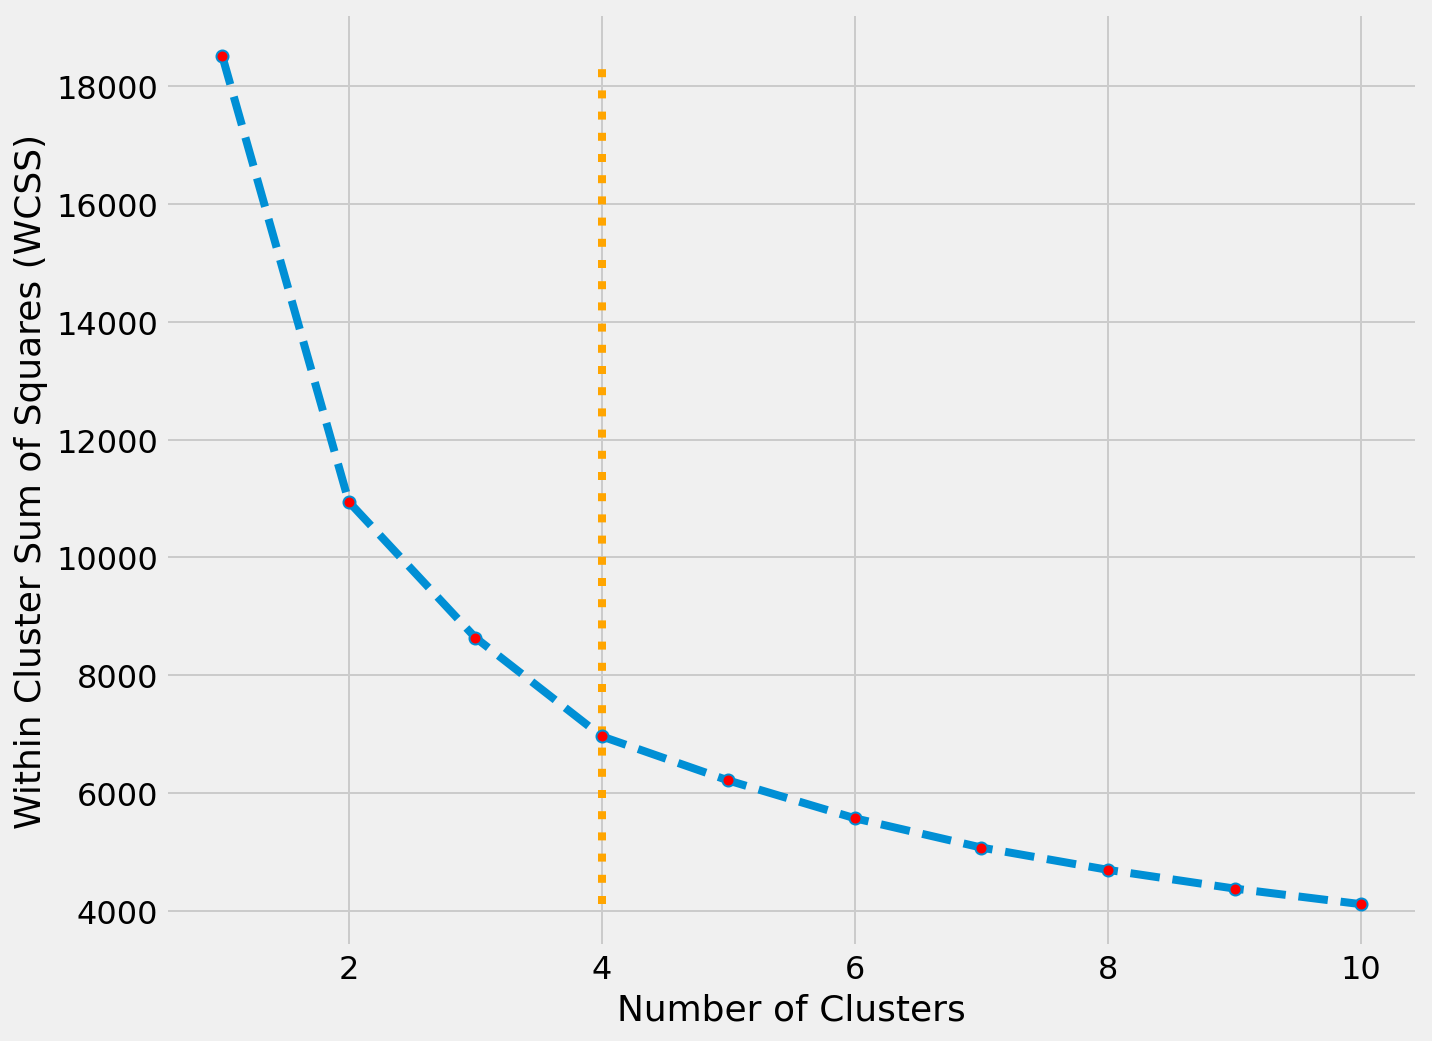

In [50]:
# Visualize the curve in order to locate the elbow
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(1, 11), wcss, marker='o', markerfacecolor='red', linestyle='--')
    plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee, ymin=min(
        wcss), ymax=max(wcss), linestyles='dotted', color='orange')
    plt.xlabel('Number of Clusters', fontsize=18)
    plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()


In [51]:
# Locate the elbow
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal # of clusters:", n_clusters)

Optimal # of clusters: 4


In [52]:
# Instantiate a KMeans model with 4 clusters, fit and predict cluster indices
kmeans_pca = KMeans(n_clusters=4, init='random', random_state=1)
kmeans_pca.fit_predict(pca_scores)
plays_km_df['km_cluster'] = kmeans_pca.labels_

In [53]:
plays_pca_km_df = pd.concat([plays_km_df.reset_index(drop=True), pd.DataFrame(
    data=pca_scores, columns=['pca_1', 'pca_2', 'pca_3', 'pca_4'])], axis=1)

In [54]:
plays_pca_km_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,km_cluster,pca_1,pca_2,pca_3,pca_4
0,0021700002,2017-10-17,1610612745,HOU,Houston,2772,Trevor Ariza,Trevor,2,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063,1,0.508313,-0.099022,0.259690,-0.031194
1,0021700002,2017-10-17,1610612745,HOU,Houston,201583,Ryan Anderson,Ryan,2,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064,1,0.463780,-0.065592,-0.088094,-0.127671
2,0021700002,2017-10-17,1610612745,HOU,Houston,203991,Clint Capela,Clint,3,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092,1,0.564571,-0.238693,-0.435644,0.169335
3,0021700002,2017-10-17,1610612745,HOU,Houston,201935,James Harden,James,1,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134,3,0.252559,0.122709,0.399441,-0.024089
4,0021700002,2017-10-17,1610612745,HOU,Houston,101108,Chris Paul,Chris,1,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068,3,0.170107,-0.146632,0.595382,0.072508


In [55]:
# check for the clusters' balance
plays_pca_km_df.km_cluster.value_counts()

2    18359
1    17655
3    14888
0    11991
Name: km_cluster, dtype: int64

In [56]:
plays_pca_km_df.groupby(['km_cluster'])[group_1].agg(np.mean)

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
km_cluster,,,,,,,
0,89.356092,0.106154,0.348179,11.094888,0.106100,0.148212,23.580352
1,108.252382,0.117357,1.098273,10.386004,0.537462,0.568360,60.872444
2,108.356207,0.109409,0.543284,10.063832,0.679576,0.701474,36.988017
3,108.802787,0.224177,2.131183,9.607348,0.496915,0.534180,65.082550


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


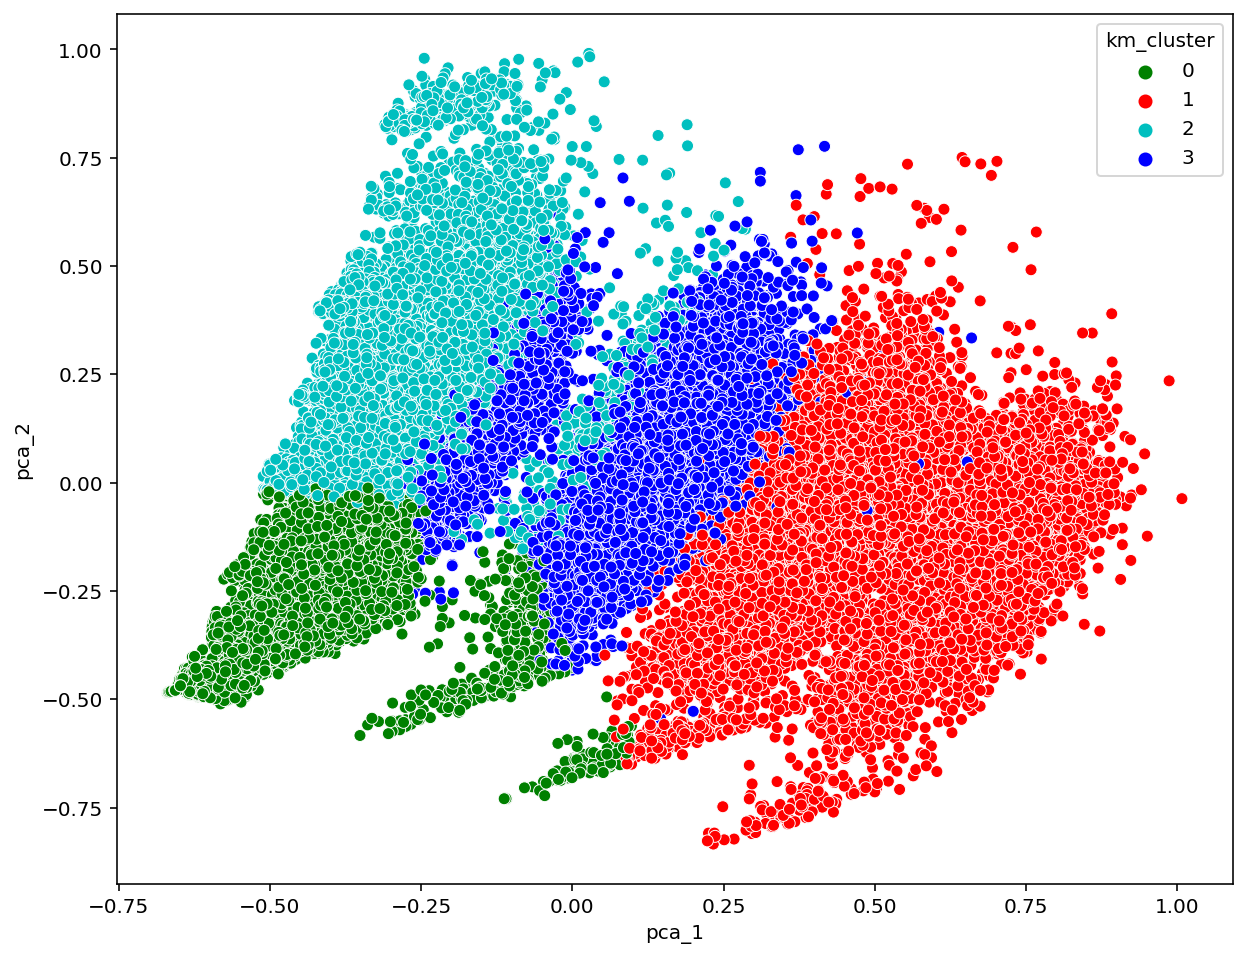

In [57]:
# visualize clusters
x_axis = plays_pca_km_df['pca_1']
y_axis = plays_pca_km_df['pca_2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue = plays_pca_km_df['km_cluster'], palette = ['g', 'r', 'c', 'b'])
plt.show()

The resulted clustering is decent, however there are many overlapping points of `cluster_2` and `cluster_3`. We are going to implement another model, which may produce even better results.
## 3.2 Gaussian Mixture Models (GMM)
GMMs are distribution-based model, rather than distance-based like K-Means. They do not assume clusters to be of any geometry, like K-Means which bias the cluster sizes to have specific structures (circular). Furthermore, they work weell with non-linear geometric distributions.

The main disadvantages concerns its potential quick convergence to a local minimum, which is not optimal. However, we can tewak its parameters appropriately, as it is shown below.

In [58]:
plays_gm_df = plays_df.copy()

In [59]:
# find the optimum number of clusters
bgm = BayesianGaussianMixture(n_components=10, n_init=7, max_iter=1000)
bgm.fit(pca_scores)
np.round(bgm.weights_, 2)

array([0.06, 0.19, 0.18, 0.19, 0.14, 0.01, 0.03, 0.05, 0.09, 0.07])

We used this method to pick the number of clusters. In brief, it returns the weights of clusters, with erroneous clusters being weighted at or near zero and basically removing them automatically.

In [60]:
# Instantiate a GM model with 4 clusters, fit and predict cluster indices
gm = GaussianMixture(n_components=4, init_params='kmeans', tol=1e-4,
                     covariance_type='full', n_init=10, random_state=1)
plays_gm_df['gm_cluster'] = gm.fit_predict(pca_scores)

In [61]:
plays_pca_gm_df = pd.concat([plays_gm_df.reset_index(drop=True), pd.DataFrame(
    data=pca_scores, columns=['pca_1', 'pca_2', 'pca_3', 'pca_4'])], axis=1)
plays_pca_gm_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,pca_1,pca_2,pca_3,pca_4
0,0021700002,2017-10-17,1610612745,HOU,Houston,2772,Trevor Ariza,Trevor,2,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063,1,0.508313,-0.099022,0.259690,-0.031194
1,0021700002,2017-10-17,1610612745,HOU,Houston,201583,Ryan Anderson,Ryan,2,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064,1,0.463780,-0.065592,-0.088094,-0.127671
2,0021700002,2017-10-17,1610612745,HOU,Houston,203991,Clint Capela,Clint,3,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092,1,0.564571,-0.238693,-0.435644,0.169335
3,0021700002,2017-10-17,1610612745,HOU,Houston,201935,James Harden,James,1,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134,3,0.252559,0.122709,0.399441,-0.024089
4,0021700002,2017-10-17,1610612745,HOU,Houston,101108,Chris Paul,Chris,1,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068,3,0.170107,-0.146632,0.595382,0.072508


In [62]:
# check for the clusters' balance
plays_pca_gm_df.gm_cluster.value_counts()

0    27508
1    17886
3    11770
2     5729
Name: gm_cluster, dtype: int64

In [63]:
plays_pca_gm_df.groupby(['gm_cluster'])[group_1].agg(np.mean)

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
gm_cluster,,,,,,,
0,105.717206,0.126598,0.758258,9.772913,0.550722,0.588245,39.160862
1,108.197048,0.118307,1.101867,10.395477,0.533829,0.564773,60.543945
2,82.131297,0.093151,0.165360,12.502479,0.000000,0.000000,14.171583
3,108.582897,0.217407,2.018245,10.009031,0.504521,0.540345,64.923704


It is apparent that `cluster_3` is better than the rest. It note higher average for the `OFF_RATING`, `AST_PCT`, `AST_TOV` & `POSS`.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


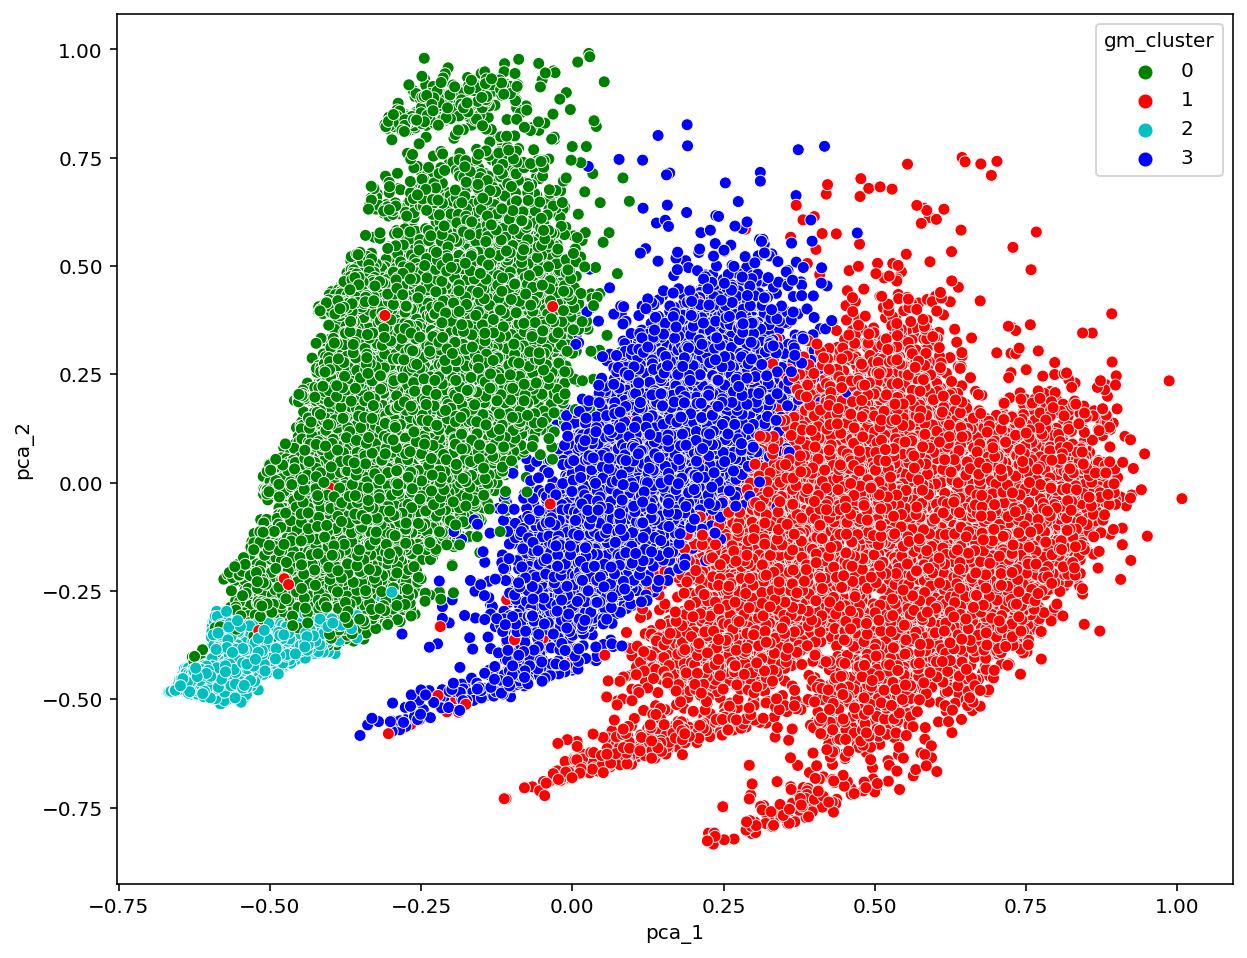

In [64]:
# visualize
x_axis = plays_pca_gm_df['pca_1']
y_axis = plays_pca_gm_df['pca_2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue = plays_pca_gm_df['gm_cluster'], palette = ['g', 'r', 'c', 'b'])
plt.show()


That's it! `cluster_3` - which performs better than the others in more features - is better separated by the other. At the same, time cluster_0 is also effectively contained, in contrast to the K-Means plot.

# 4. Evaluation
## 4.1 Basic Evaluation
Next we are about to evaluate the utilisation of the clusters. We begin with comparing the sorted by `AST_PCT` upper segment of the dataset with the distribution of `cluster_3`. This is done, so as to prove that clustering is, indeed, better for the case, than plain grouping the dataset by a specific feature's upper quartile.

In [65]:
# switch to more plesant dataset name
clustered_plays_df = plays_pca_gm_df.copy()

In [96]:
plays_df_95 = plays_df.loc[plays_df['AST_PCT'] > plays_df['AST_PCT'].quantile(0.95), group_1]
plays_df_95.describe()

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
count,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000
mean,104.781872,0.527235,2.929741,9.501309,0.472252,0.509817,48.632199
std,23.812656,0.142249,2.974245,8.700416,0.274866,0.267038,25.562033
min,22.200000,0.406000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,93.000000,0.440000,0.000000,0.000000,0.333000,0.383000,28.000000
50%,105.900000,0.500000,2.310000,8.700000,0.500000,0.532000,53.000000
75%,118.200000,0.545000,4.000000,14.300000,0.625000,0.666000,70.000000
max,250.000000,1.000000,17.000000,66.700000,1.500000,1.500000,121.000000


In [67]:
clustered_plays_df.loc[clustered_plays_df.gm_cluster == 3, group_1].describe()

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
count,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000
mean,108.582897,0.217407,2.018245,10.009031,0.504521,0.540345,64.923704
std,15.444219,0.140678,2.152729,7.608290,0.196056,0.186170,13.593048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,98.600000,0.111000,0.500000,4.800000,0.385000,0.429000,57.000000
50%,108.500000,0.200000,1.500000,9.100000,0.500000,0.545000,66.000000
75%,118.575000,0.308000,3.000000,14.300000,0.625000,0.654000,74.000000
max,185.700000,1.000000,17.000000,100.000000,1.500000,1.500000,121.000000


Segmenting by the 95 percentile of `AST_PCT`, which means that the `AST_TOV` gets also shifted to the upper limit (they both correlate positively), leads to a sample of plays that notes remarkable high levels at both features. However, no other feature is sufficient enough. That is adequately explained in the `00_EDA.ipynb` notebook.

By clustering the dataset in a more advanced way and taking into account all the features, we managed to result in way better segments (i.e. clusters) of the same dataset. Here, we cultivate our approach on the `cluster_3` and obviously we see that the features of `OFF_RATING`, `TM_TOV_PCT`, `EFG_PCT`, `TS_PCT` & `POSS` lead the run, while the `AST_PCT` and `AST_TOV` retain a decent level!

Let's depict them with Box Plots.

In [68]:
# Visualizing scatter plots

def visualize_df_box_plot(df, title):
    """
    Takes in a dataframe and the title of the plot.
    It returns a Whiskers Box Plot.
    Parameters
    ---------
    df           : a dataframe object
             Represents the dataframe to be depicted
    title        : a string
             Passes the title of the plot
    Returns
    -------
    plot : plot
            A Box plot
    """
    with plt.style.context("fivethirtyeight"):
        df.boxplot(
            vert=False,
            figsize=(13, 6),
            showfliers=False,
            showmeans=True,
            patch_artist=True,
            boxprops=dict(linestyle="-", linewidth=1.5),
            flierprops=dict(linestyle="-", linewidth=1.5),
            medianprops=dict(linestyle="-", linewidth=1.5),
            whiskerprops=dict(linestyle="-", linewidth=1.5),
            capprops=dict(linestyle="-", linewidth=1.5),
        )
        plt.title(title, fontsize=16, fontweight="heavy")
        plt.show()

In [69]:
def visualize_s_box_plot(s, title):
    """
    Takes in a pd.Series and the title of the plot.
    It returns a Whiskers Box Plot.
    Parameters
    ---------
    series       : a Series object
             Represents the pd.Series to be depicted
    title        : a string
             Passes the title of the plot
    Returns
    -------
    plot : plot
            A Box plot
    """
    with plt.style.context("fivethirtyeight"):
        s.plot.box(
            vert=False,
            figsize=(13, 4),
            showfliers=False,
            showmeans=True,
            patch_artist=True,
            boxprops=dict(linestyle="-", linewidth=1.5),
            flierprops=dict(linestyle="-", linewidth=1.5),
            medianprops=dict(linestyle="-", linewidth=1.5),
            whiskerprops=dict(linestyle="-", linewidth=1.5),
            capprops=dict(linestyle="-", linewidth=1.5),
        )
        plt.title(title, fontsize=16, fontweight="heavy")
        plt.show()

In [70]:
# classify features by range/outliers
set_1 = ['OFF_RATING', 'TM_TOV_PCT', 'POSS']
set_2 = ['AST_PCT', 'EFG_PCT', 'TS_PCT']
set_3 = ['AST_TOV']

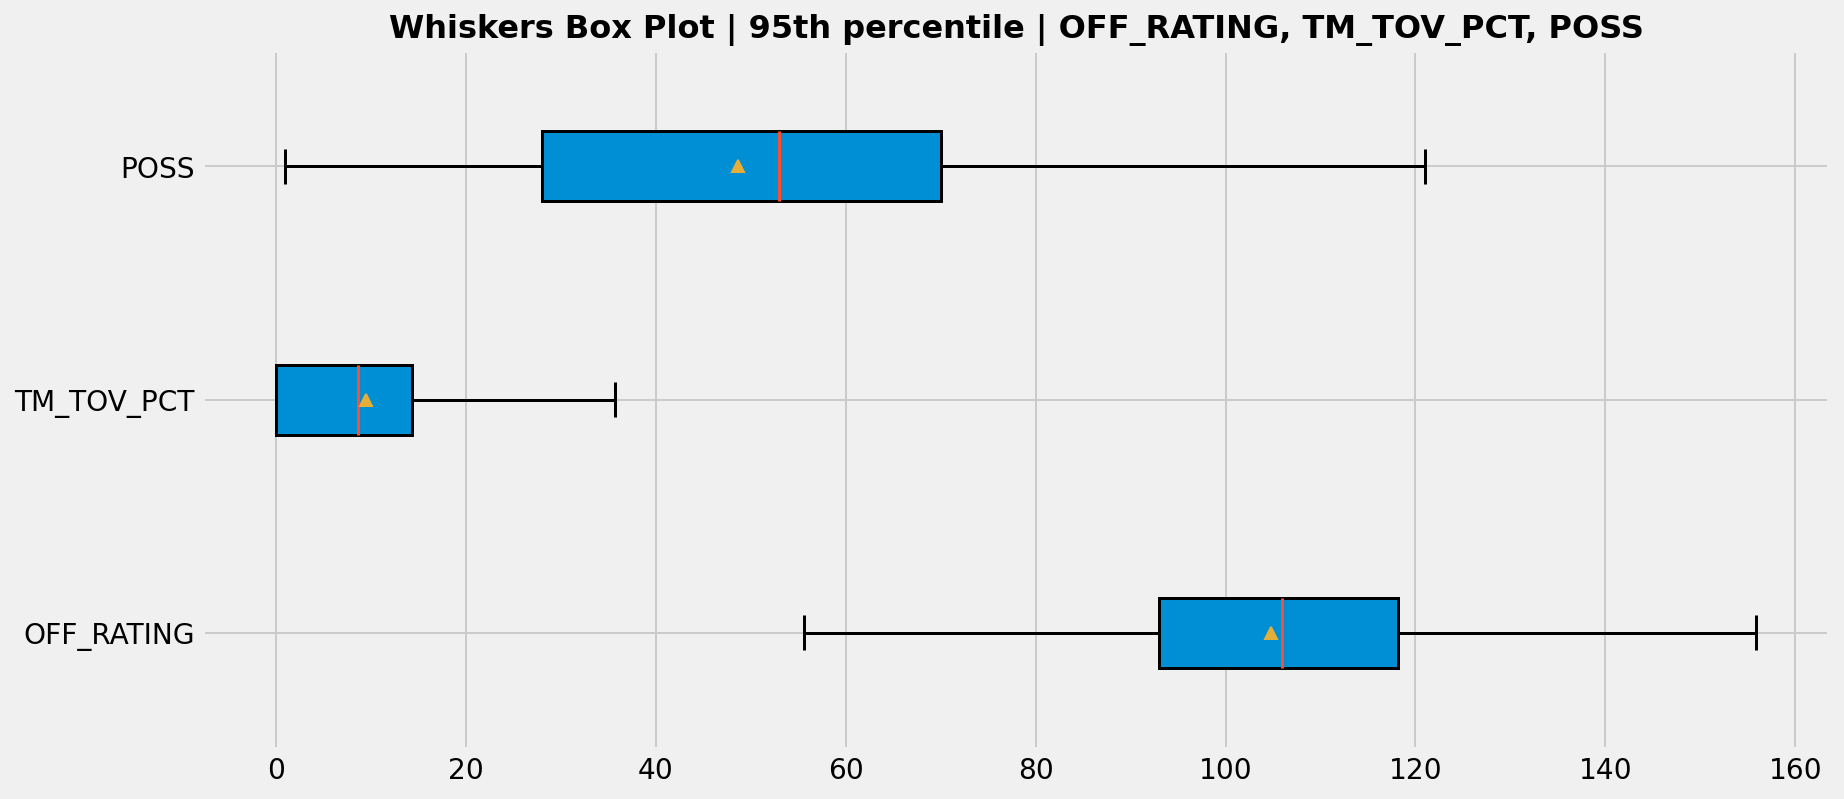

In [98]:
visualize_df_box_plot(plays_df_95.loc[:, set_1], 'Whiskers Box Plot | 95th percentile | OFF_RATING, TM_TOV_PCT, POSS')

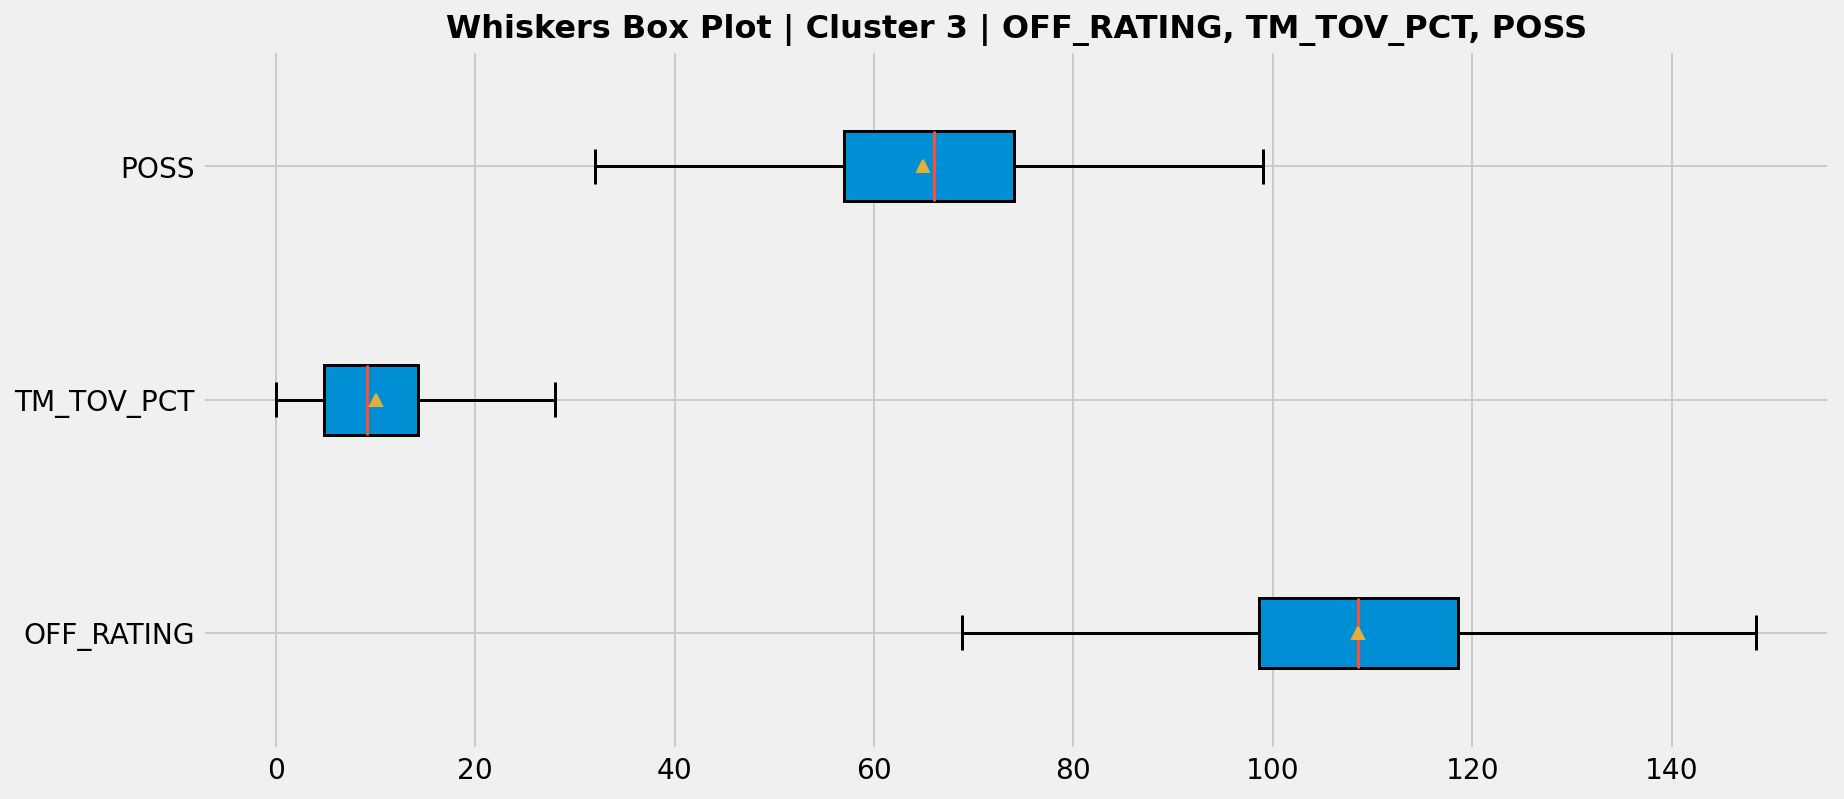

In [72]:
visualize_df_box_plot(clustered_plays_df.loc[clustered_plays_df.gm_cluster == 3, set_1], 'Whiskers Box Plot | Cluster 3 | OFF_RATING, TM_TOV_PCT, POSS')

It is obvious that in `cluster_3` all of them get a rise. 
* `POSS` Mean (64.92) and Median (66.00) both shift to the right in comparison with the 95th percentile (48.63) and (53), respectively.
* The `TM_TOV_PCT` variable shifts slightly to the right, with a marginally higher Mean.
* `OFF_RATING`, also, notes a decent rise with the Mean leveling at 108.58 instead of 104.78 and the Median at 108.5 instead of 105.9 (95th percentile).

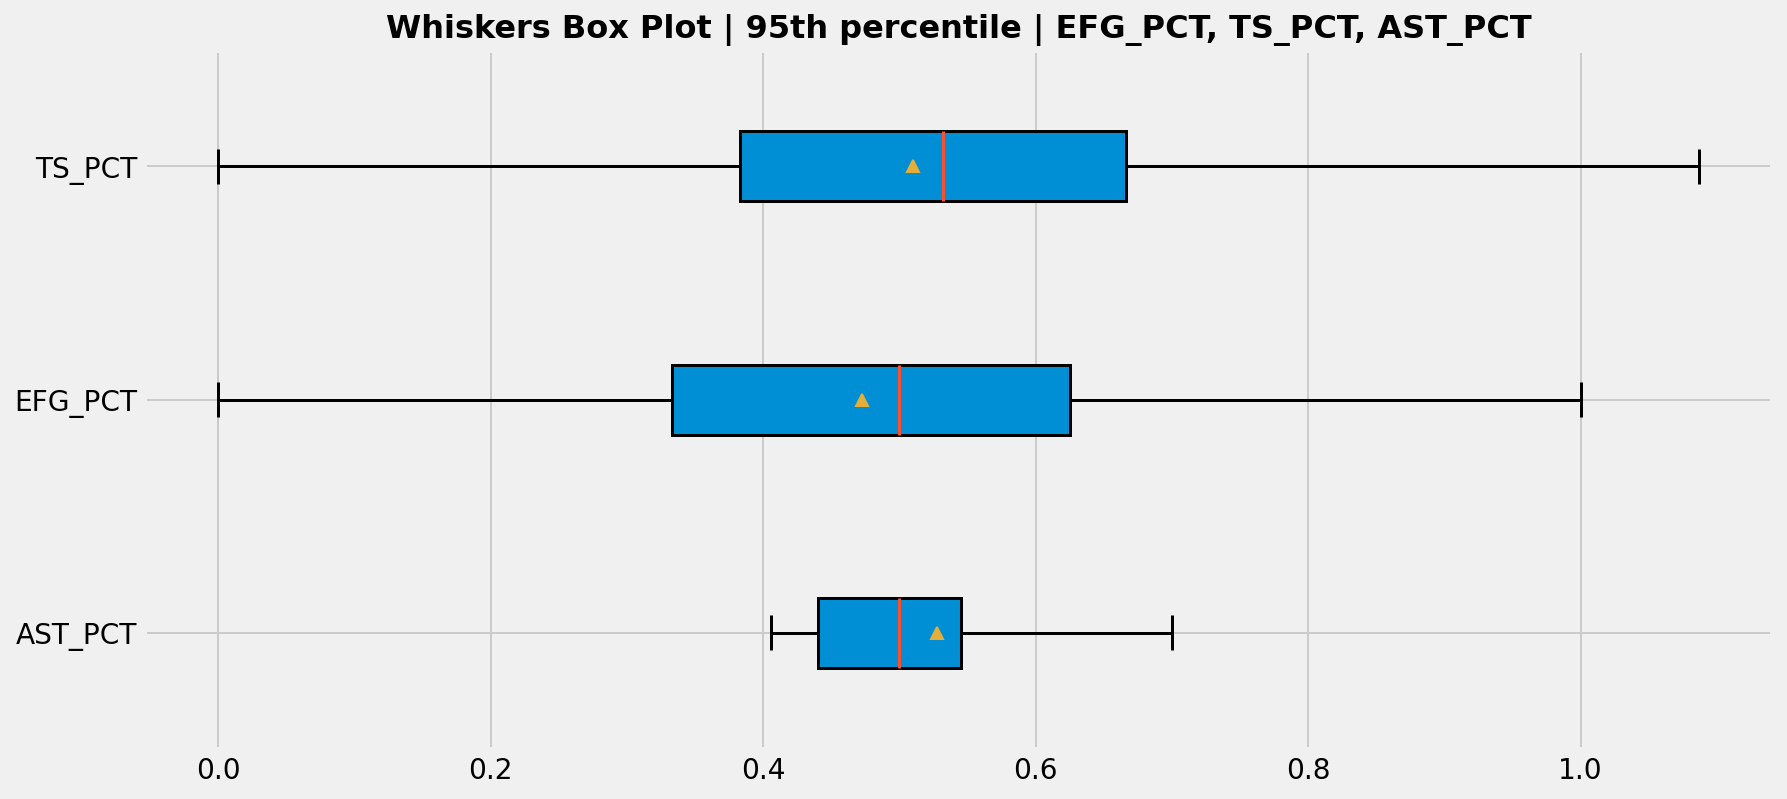

In [101]:
visualize_df_box_plot(plays_df_95[set_2], 'Whiskers Box Plot | 95th percentile | EFG_PCT, TS_PCT, AST_PCT')

In [97]:
plays_df_95.describe()

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
count,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000
mean,104.781872,0.527235,2.929741,9.501309,0.472252,0.509817,48.632199
std,23.812656,0.142249,2.974245,8.700416,0.274866,0.267038,25.562033
min,22.200000,0.406000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,93.000000,0.440000,0.000000,0.000000,0.333000,0.383000,28.000000
50%,105.900000,0.500000,2.310000,8.700000,0.500000,0.532000,53.000000
75%,118.200000,0.545000,4.000000,14.300000,0.625000,0.666000,70.000000
max,250.000000,1.000000,17.000000,66.700000,1.500000,1.500000,121.000000


In [75]:
clustered_plays_df.loc[clustered_plays_df.gm_cluster == 3, group_1].describe()


,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
count,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000
mean,108.582897,0.217407,2.018245,10.009031,0.504521,0.540345,64.923704
std,15.444219,0.140678,2.152729,7.608290,0.196056,0.186170,13.593048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,98.600000,0.111000,0.500000,4.800000,0.385000,0.429000,57.000000
50%,108.500000,0.200000,1.500000,9.100000,0.500000,0.545000,66.000000
75%,118.575000,0.308000,3.000000,14.300000,0.625000,0.654000,74.000000
max,185.700000,1.000000,17.000000,100.000000,1.500000,1.500000,121.000000


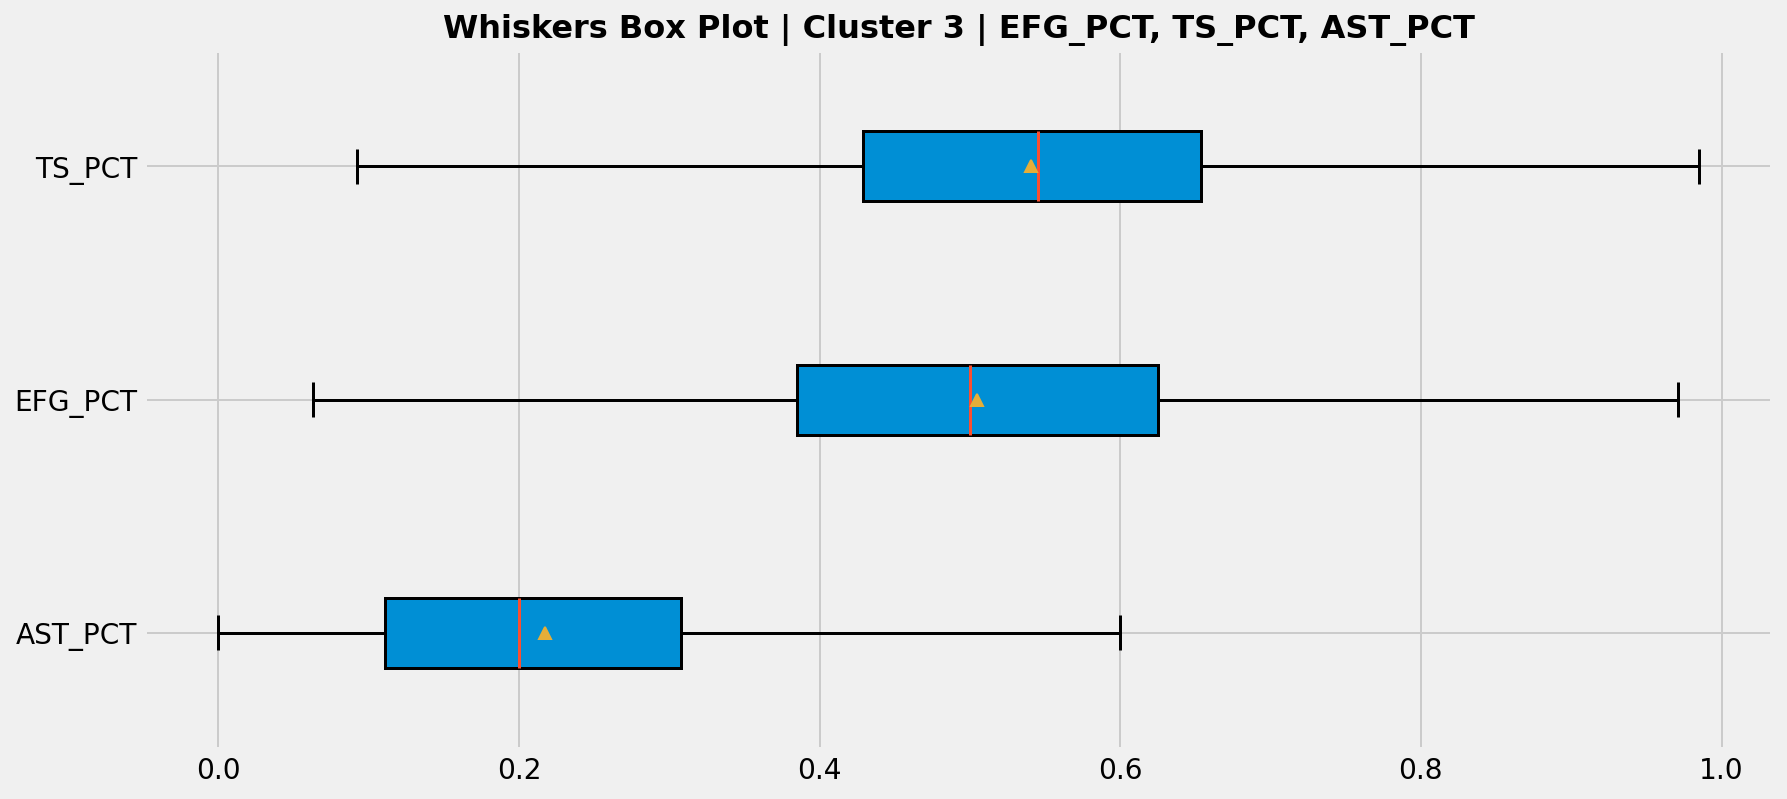

In [76]:
visualize_df_box_plot(clustered_plays_df.loc[clustered_plays_df.gm_cluster == 3, set_2], 'Whiskers Box Plot | Cluster 3 | EFG_PCT, TS_PCT, AST_PCT')

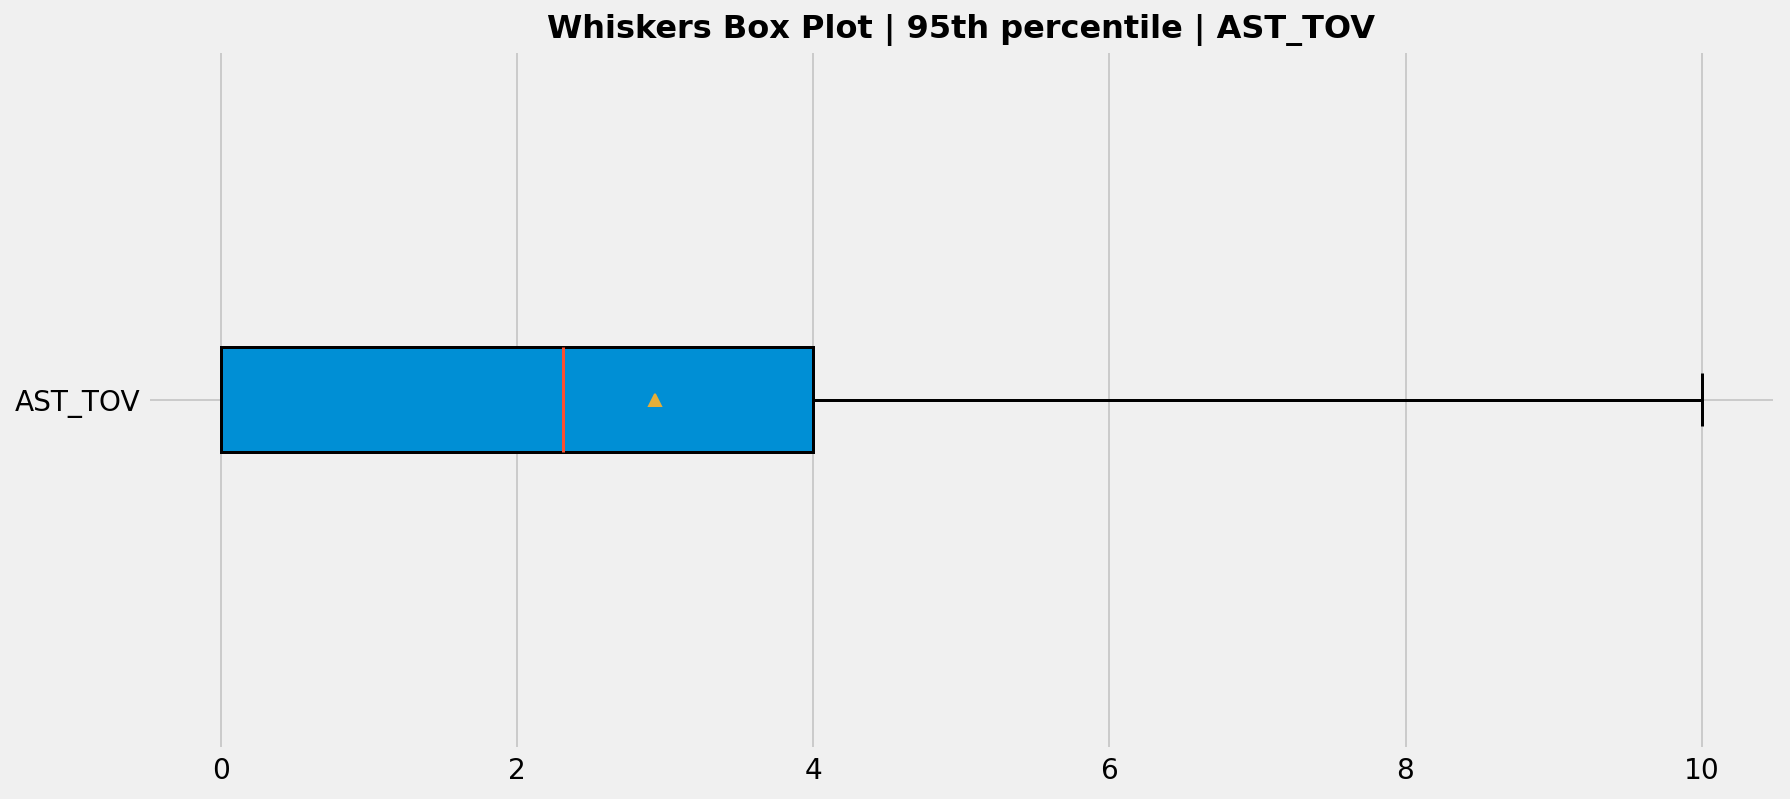

In [103]:
visualize_df_box_plot(plays_df_95[set_3], 'Whiskers Box Plot | 95th percentile | AST_TOV')

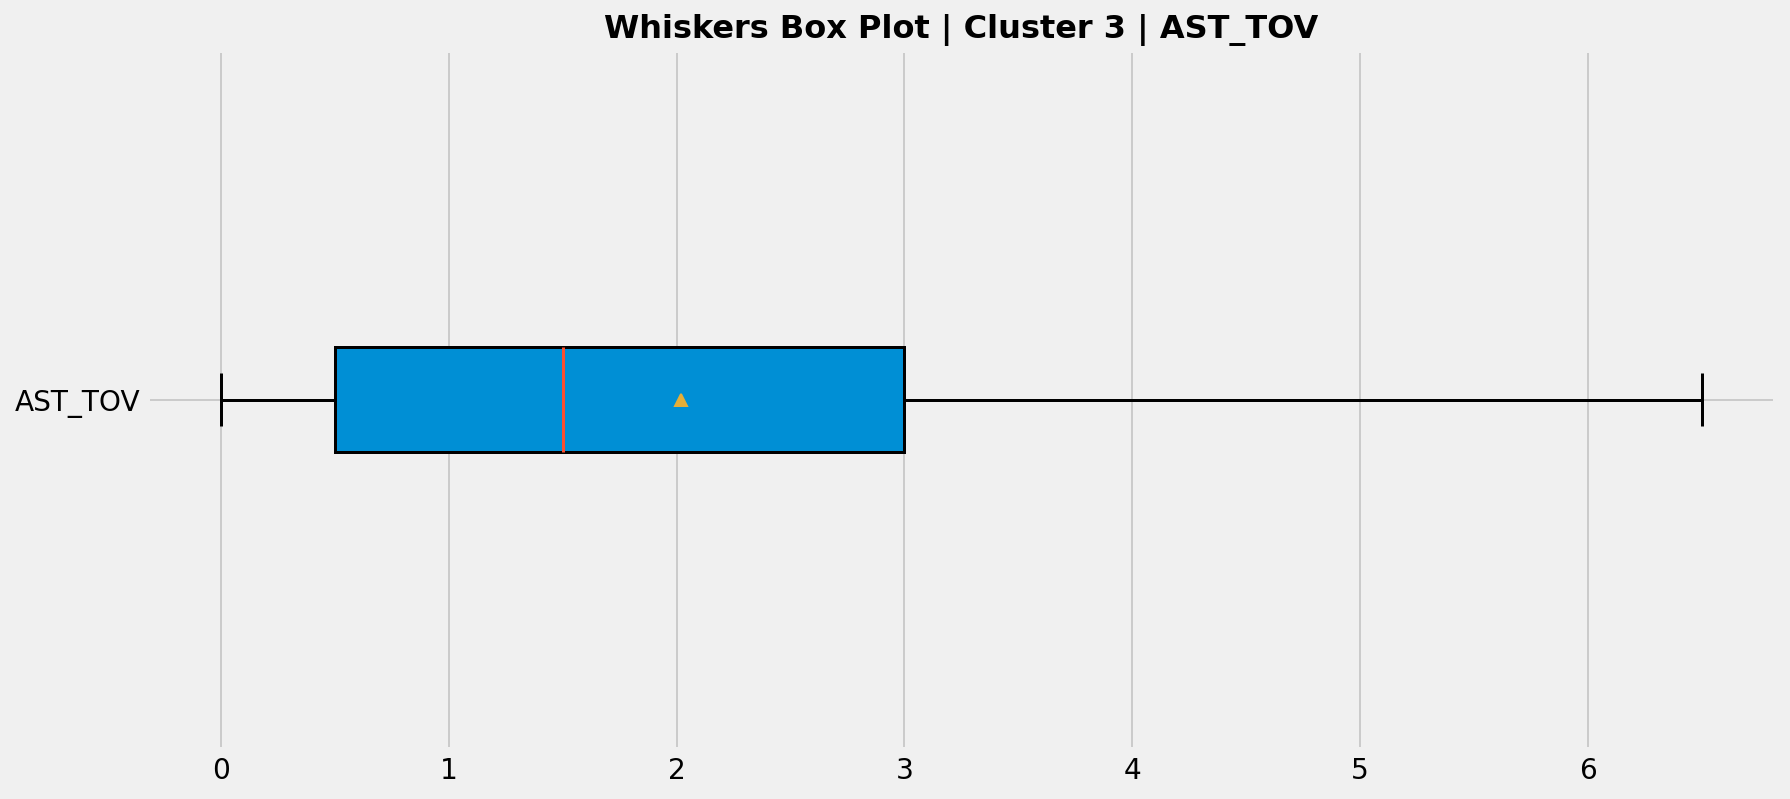

In [78]:
visualize_df_box_plot(clustered_plays_df.loc[clustered_plays_df.gm_cluster == 3, set_3], 'Whiskers Box Plot | Cluster 3 | AST_TOV')

Apart from the `AST_PCT` and `AST_TOV` which prevail in the 95th percentile, all the other features increase for the case of clustering.
* `TS_PCT` Mean (0.54) and Median (0.545) for `cluster_3` both surpass the 95th percentile ones, 0.51 and 0.532, respectively.
* `EFG_PCT` Mean gets a slight rise towards the right.

## 4.2 Quantified Evaluation
In addition, we introduce a new variable which depicts the net score of those features. That is, each group is weighted in order to better express the magnitude it has on the final assessment and the algebric sum of them is calculated. More specifically:

`NET_SCORE` = `0.5` * `group_1` + `0.3` * `group_2` + `0.2` * `group_3` + `0.0` * `group_4` + `-0.3` * `group_5`

___
- `group_4` is used for the `START_POSITION` feature which is categorical in nature and shouldn't be scored (being a center '5' does not mean to be 'more' of something a guard '1' stands for!)
- `group_5` is used for the `DEF_RATING` feature which is negative in nature and should subtracted from the Net Score.
- `NET_SCORE` is not taken into account as a feature in any of the ML models, yet we can guide out investigation way more effectively, as it quantifies our choices, accordingly.

So, let's score the sample!

In [79]:
# allocate weights
wts = []

for col in features:
    if col in group_1:
        wts.append(0.5)
    elif col in group_2:
        wts.append(0.3)
    elif col in group_3:
        wts.append(0.2)
    elif col in group_4:
        wts.append(0)
    else:
        wts.append(-0.3)
wts

[0,
 0.3,
 0.5,
 -0.3,
 0.5,
 0.5,
 0.3,
 0.2,
 0.3,
 0.2,
 0.5,
 0.5,
 0.5,
 0.2,
 0.2,
 0.2,
 0.5,
 0.2]

In [80]:
# make a dictionary of key:value feature: weight
weights_dict = dict(zip(features, wts))
weights_dict

{'START_POSITION': 0,
 'MIN': 0.3,
 'OFF_RATING': 0.5,
 'DEF_RATING': -0.3,
 'AST_PCT': 0.5,
 'AST_TOV': 0.5,
 'AST_RATIO': 0.3,
 'OREB_PCT': 0.2,
 'DREB_PCT': 0.3,
 'REB_PCT': 0.2,
 'TM_TOV_PCT': 0.5,
 'EFG_PCT': 0.5,
 'TS_PCT': 0.5,
 'USG_PCT': 0.2,
 'PACE': 0.2,
 'PACE_PER40': 0.2,
 'POSS': 0.5,
 'PIE': 0.2}

In [81]:
# segment the eligible for score original dataset
scores_df = plays_df.loc[:, features].copy()
scores_df

,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
0,2,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063
1,2,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064
2,3,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092
3,1,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134
4,1,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62888,0,1155,92.5,104.9,0.000,0.00,0.0,0.000,0.038,0.020,0.0,0.250,0.410,0.104,100.99,84.16,40,0.016
62889,0,1869,107.6,98.5,0.235,1.33,15.4,0.056,0.116,0.089,11.5,0.471,0.533,0.278,102.47,85.39,66,0.154
62890,0,739,70.4,121.4,0.000,0.00,0.0,0.000,0.167,0.081,14.3,0.000,0.170,0.206,107.17,89.31,27,-0.039
62891,0,472,94.1,118.8,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.500,0.500,0.100,100.68,83.90,17,0.049


In [82]:
# the calculations to be executed
plays_df['NET_SCORE'] = scores_df.dot(pd.Series(weights_dict))
plays_df.sample(20)

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,NET_SCORE
3449,0021700162,2017-11-08,1610612748,MIA,Miami,1626196,Josh Richardson,Josh,2,1735,114.1,92.3,0.038,1.00,14.3,0.040,0.156,0.105,14.3,0.400,0.400,0.088,107.07,89.22,64,0.014,633.5732
18357,0021700862,2018-02-14,1610612747,LAL,Los Angeles,1627780,Gary Payton II,Gary,0,991,97.1,128.2,0.000,0.00,0.0,0.091,0.000,0.061,0.0,0.500,0.500,0.095,107.53,89.61,35,0.013,364.8700
38124,0021800563,2019-01-03,1610612761,TOR,Toronto,1628449,Chris Boucher,Chris,0,283,166.7,60.0,0.000,0.00,0.0,0.250,0.143,0.182,0.0,0.500,0.500,0.300,96.68,80.57,9,0.143,190.9179
13136,0021700616,2018-01-11,1610612746,LAC,LA,1628393,Jawun Evans,Jawun,0,1349,116.7,84.0,0.118,2.00,25.0,0.000,0.040,0.023,12.5,0.250,0.410,0.113,104.62,87.18,48,0.056,515.3994
4212,0021700198,2017-11-13,1610612743,DEN,Denver,1627750,Jamal Murray,Jamal,1,2341,92.2,102.6,0.000,0.00,0.0,0.089,0.032,0.066,22.2,0.368,0.434,0.297,95.34,79.45,77,0.017,802.6824
55580,0021900160,2019-11-13,1610612757,POR,Portland,203918,Rodney Hood,Rodney,2,1945,112.7,120.0,0.053,0.50,5.3,0.000,0.071,0.029,10.5,0.767,0.787,0.231,94.77,78.97,63,0.148,678.0944
23433,0021701107,2018-03-26,1610612756,PHX,Phoenix,203584,Troy Daniels,Troy,1,2167,105.8,121.7,0.000,0.00,0.0,0.026,0.132,0.079,5.9,0.563,0.563,0.213,91.71,76.42,69,0.081,738.2484
13825,0021700650,2018-01-16,1610612738,BOS,Boston,201143,Al Horford,Al,2,2250,101.3,102.6,0.250,3.00,35.3,0.049,0.171,0.110,11.8,0.778,0.778,0.126,99.20,82.67,77,0.144,788.7741
12234,0021700576,2018-01-05,1610612757,POR,Portland,203994,Jusuf Nurkic,Jusuf,3,1354,111.1,84.8,0.188,3.00,21.4,0.100,0.259,0.191,7.1,0.500,0.564,0.220,96.78,80.65,45,0.184,506.6087
62081,0021900471,2019-12-27,1610612744,GSW,Golden State,1626161,Willie Cauley-Stein,Willie,3,1503,117.0,90.9,0.053,0.00,12.5,0.067,0.087,0.075,0.0,0.667,0.615,0.115,103.47,86.23,53,0.088,551.0826


In [83]:
# segment the eligible for score clustered dataset
clustered_scores_df = clustered_plays_df.loc[:, features].copy()
clustered_scores_df

,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
0,2,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063
1,2,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064
2,3,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092
3,1,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134
4,1,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62888,0,1155,92.5,104.9,0.000,0.00,0.0,0.000,0.038,0.020,0.0,0.250,0.410,0.104,100.99,84.16,40,0.016
62889,0,1869,107.6,98.5,0.235,1.33,15.4,0.056,0.116,0.089,11.5,0.471,0.533,0.278,102.47,85.39,66,0.154
62890,0,739,70.4,121.4,0.000,0.00,0.0,0.000,0.167,0.081,14.3,0.000,0.170,0.206,107.17,89.31,27,-0.039
62891,0,472,94.1,118.8,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.500,0.500,0.100,100.68,83.90,17,0.049


In [84]:
# the calculations to be executed
clustered_plays_df['NET_SCORE'] = clustered_scores_df.dot(pd.Series(weights_dict))
clustered_plays_df.sample(20)

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,pca_1,pca_2,pca_3,pca_4,NET_SCORE
57785,0021900254,2019-11-27,1610612765,DET,Detroit,203503,Tony Snell,Tony,0,1171,107.7,90.0,0.000,0.0,0.0,0.000,0.103,0.057,0.0,0.000,0.000,0.043,97.15,80.96,39,-0.016,2,-0.407851,-0.361949,0.009613,-0.254194,433.3197
12237,0021700576,2018-01-05,1610612757,POR,Portland,202334,Ed Davis,Ed,0,1090,117.5,92.3,0.071,0.5,10.0,0.182,0.158,0.167,20.0,0.833,0.872,0.209,104.37,86.97,40,0.139,0,-0.208878,0.370748,-0.173041,0.004335,430.6528
57749,0021900261,2019-11-27,1610612749,MIL,Milwaukee,1628425,Sterling Brown,Sterling,0,760,100.0,81.5,0.111,1.0,25.0,0.000,0.235,0.129,25.0,0.500,0.500,0.107,96.64,80.54,24,0.093,0,-0.366979,0.042681,-0.043462,0.138214,322.1778
38600,0021800586,2019-01-06,1610612746,LAC,LA,1628414,Sindarius Thornwell,Sindarius,0,115,100.0,225.0,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,100.17,83.48,4,0.000,2,-0.628780,-0.447662,-0.185744,0.015277,55.7300
56244,0021900189,2019-11-18,1610612739,CLE,Cleveland,203521,Matthew Dellavedova,Matthew,0,705,104.2,72.0,0.286,2.0,33.3,0.000,0.105,0.067,16.7,0.750,0.868,0.148,100.11,83.43,24,0.209,0,-0.303189,0.328553,0.029580,0.296263,311.1163
19846,0021700929,2018-03-02,1610612764,WAS,Washington,201975,Jodie Meeks,Jodie,0,319,80.0,172.7,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.071,94.80,79.00,10,-0.071,2,-0.589539,-0.434304,-0.148412,-0.043674,123.6500
14344,0021700678,2018-01-20,1610612749,MIL,Milwaukee,1627850,Marshall Plumlee,Marshall,0,550,71.4,90.9,0.000,0.0,0.0,0.111,0.357,0.261,40.0,1.000,1.087,0.208,112.58,93.82,21,0.326,0,-0.279765,0.454704,-0.466228,0.130124,246.5418
25287,0021701196,2018-04-07,1610612759,SAS,San Antonio,1627854,Bryn Forbes,Bryn,0,769,85.2,128.0,0.000,0.0,0.0,0.000,0.067,0.036,0.0,0.000,0.000,0.071,97.41,81.18,27,-0.022,2,-0.488323,-0.396184,-0.062153,-0.161100,284.1551
48856,0021801073,2019-03-20,1610612757,POR,Portland,1629018,Gary Trent Jr.,Gary,0,404,88.2,94.1,0.000,0.0,0.0,0.000,0.167,0.083,50.0,0.000,0.000,0.118,121.19,100.99,17,-0.068,2,-0.547568,-0.433665,-0.168111,-0.075513,215.0827
14627,0021700695,2018-01-22,1610612746,LAC,LA,1626149,Montrezl Harrell,Montrezl,0,1885,113.0,117.6,0.000,0.0,0.0,0.192,0.057,0.115,5.3,0.571,0.656,0.241,104.66,87.22,69,0.126,0,-0.102601,0.228386,-0.018065,-0.357933,663.0114


In [85]:
# score clusters
clustered_plays_df.groupby(['gm_cluster'])[group_1 + ['NET_SCORE']].agg(np.mean)

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS,NET_SCORE
gm_cluster,,,,,,,,
0,105.717206,0.126598,0.758258,9.772913,0.550722,0.588245,39.160862,422.192820
1,108.197048,0.118307,1.101867,10.395477,0.533829,0.564773,60.543945,621.134763
2,82.131297,0.093151,0.165360,12.502479,0.000000,0.000000,14.171583,193.313073
3,108.582897,0.217407,2.018245,10.009031,0.504521,0.540345,64.923704,662.488581


It is now very comfortable to classify clusters by their contribution to the player's specific stats we initially marked as significant. So, sorted by scoring:
1. `cluster_3`
2. `cluster_1`
3. `cluster_0`
4. `cluster_2`

In [87]:
plays_df.loc[plays_df['AST_PCT'] > plays_df['AST_PCT'].quantile(0.95), [
    'NET_SCORE']].describe()

,NET_SCORE
count,3056.000000
mean,515.840837
std,232.666886
min,42.695600
25%,319.701525
50%,561.006700
75%,715.238350
max,1138.453000


In [88]:
clustered_plays_df.loc[clustered_plays_df.gm_cluster == 3, ['NET_SCORE']].describe()

,NET_SCORE
count,11770.000000
mean,662.488581
std,122.246609
min,3.330200
25%,589.104975
50%,676.411500
75%,750.768800
max,1138.453000


In [104]:
plays_scored_df_95 = plays_df.loc[plays_df['AST_PCT'] > plays_df['AST_PCT'].quantile(0.95), ['NET_SCORE']]

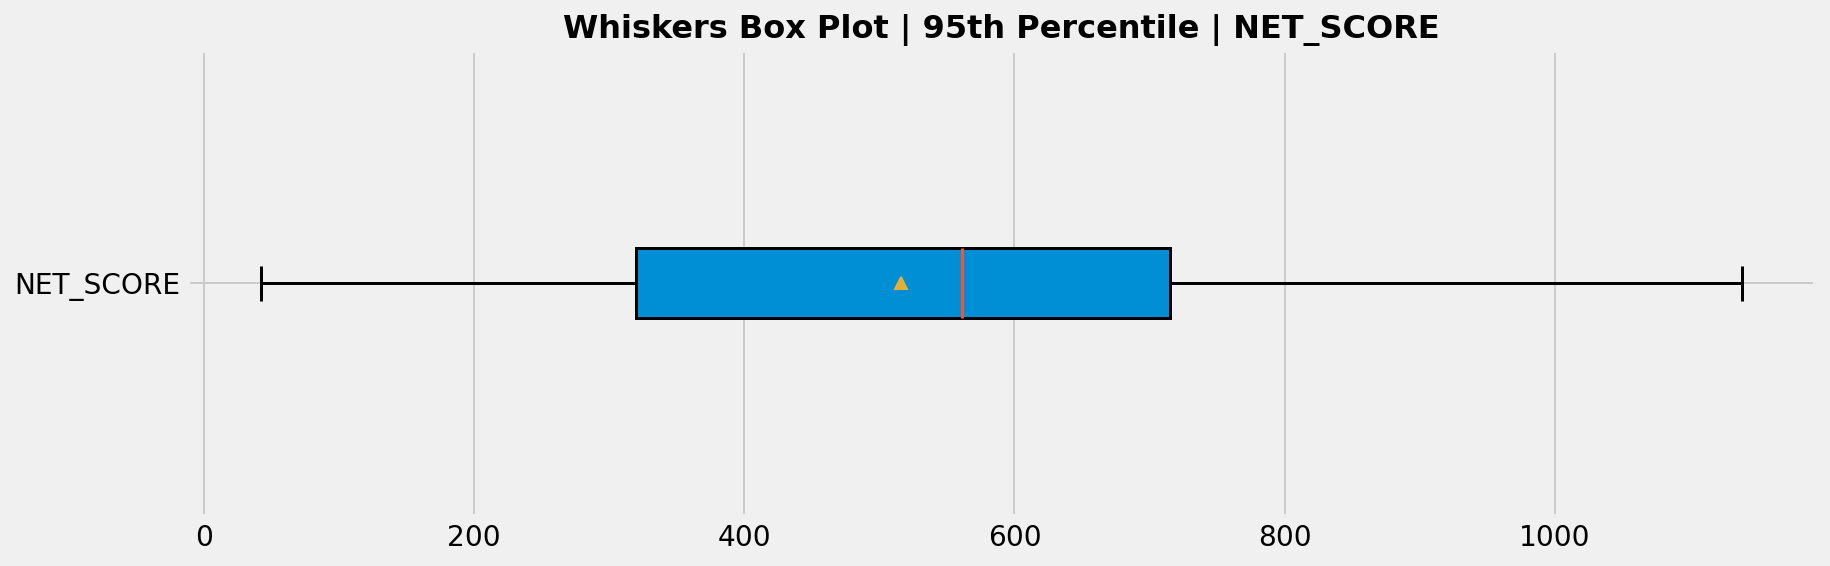

In [105]:
visualize_s_box_plot(plays_scored_df_95, 'Whiskers Box Plot | 95th Percentile | NET_SCORE')

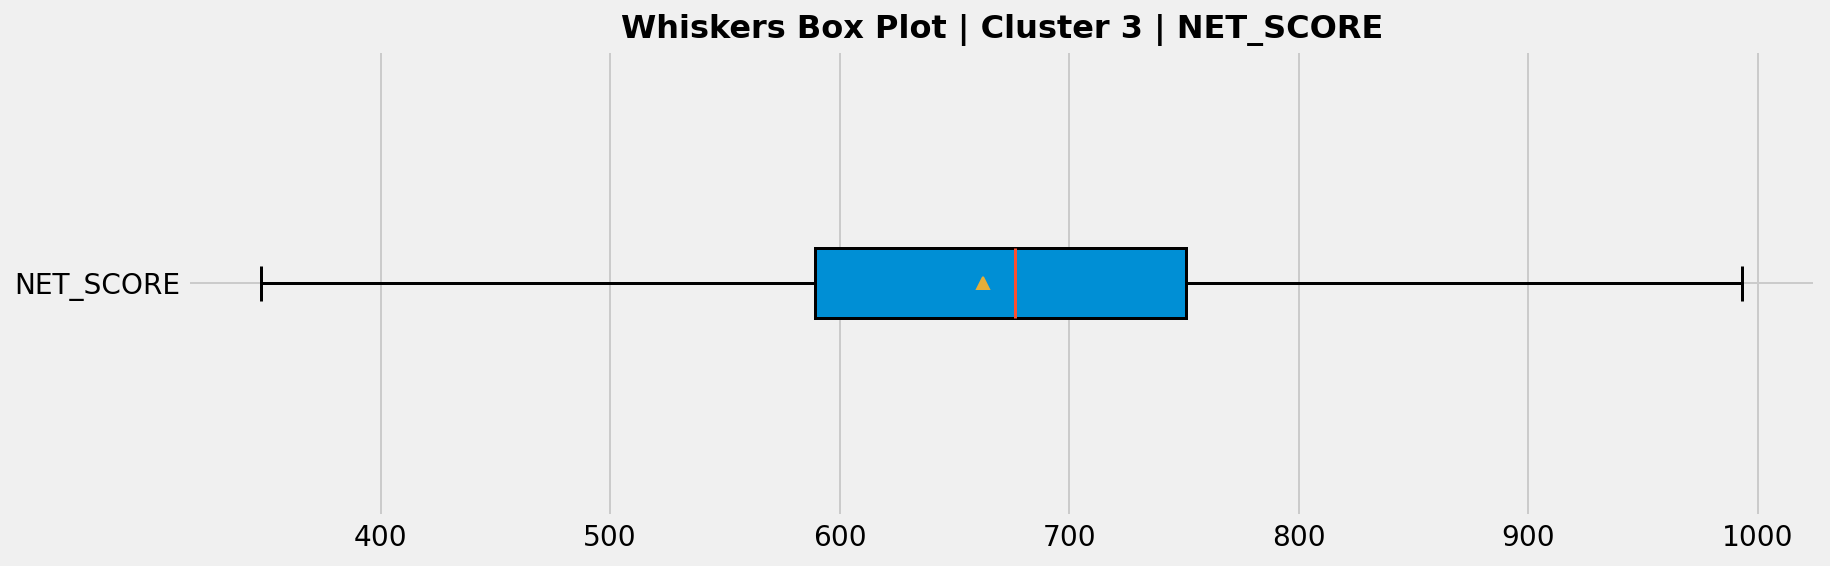

In [91]:
visualize_s_box_plot(clustered_plays_df.loc[clustered_plays_df.gm_cluster == 3, 'NET_SCORE'], 'Whiskers Box Plot | Cluster 3 | NET_SCORE')

Both arithmetically and visually, it becomes apparent that `cluster_3` dominates the 95th percentile segment. Specifically, the `NET_SCORE` Mean increases by 146.5 (662.4-515.9), while the Median by 115.4 (676.4-561.0).

# 5. Conclusion

Starting from a basic approch of sorting the dataset by a master feature (`AST_PCT`), taking the upper segment of it and evaluate the plays 'horizontally' (along all the features), we realised that it was not feasible to get in a valid outcome. That is, by maximizing along one feature, many of the rest get worse (ref. `00_EDA.ipynb`).

In this section, we tried clustering algorithms in an effort to effectively segment data and capture the underlying patterns, which may lead us to the best player. Indeed, we resulted in a powerful segment of plays (`cluster_3`) where most of the features are in high level. This achievement took place by taking into account all the significant variables and not just one, as in the case of upper percentile (`AST_PCT`). Hence, proving the point that clustering promotes a more comprehensive separation of data, deriving from signals of more components.

Finally, we achieved our goal and came up to a meaningful approach in order to chech for a candidate player. Id est, we can just examine a player for their participation or not to the requisite `cluster_3`.

In [92]:
clustered_plays_df

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE,gm_cluster,pca_1,pca_2,pca_3,pca_4,NET_SCORE
0,0021700002,2017-10-17,1610612745,HOU,Houston,2772,Trevor Ariza,Trevor,2,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063,1,0.508313,-0.099022,0.259690,-0.031194,790.8176
1,0021700002,2017-10-17,1610612745,HOU,Houston,201583,Ryan Anderson,Ryan,2,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064,1,0.463780,-0.065592,-0.088094,-0.127671,704.4737
2,0021700002,2017-10-17,1610612745,HOU,Houston,203991,Clint Capela,Clint,3,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092,1,0.564571,-0.238693,-0.435644,0.169335,396.9053
3,0021700002,2017-10-17,1610612745,HOU,Houston,201935,James Harden,James,1,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134,3,0.252559,0.122709,0.399441,-0.024089,771.5868
4,0021700002,2017-10-17,1610612745,HOU,Houston,101108,Chris Paul,Chris,1,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068,3,0.170107,-0.146632,0.595382,0.072508,709.6390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62888,0021900503,2019-12-31,1610612760,OKC,Oklahoma City,1628977,Hamidou Diallo,Hamidou,0,1155,92.5,104.9,0.000,0.00,0.0,0.000,0.038,0.020,0.0,0.250,0.410,0.104,100.99,84.16,40,0.016,0,-0.340573,-0.084298,-0.075286,-0.208324,418.6794
62889,0021900503,2019-12-31,1610612760,OKC,Oklahoma City,203471,Dennis Schroder,Dennis,0,1869,107.6,98.5,0.235,1.33,15.4,0.056,0.116,0.089,11.5,0.471,0.533,0.278,102.47,85.39,66,0.154,0,-0.120534,0.158886,0.223270,-0.201665,667.3267
62890,0021900503,2019-12-31,1610612760,OKC,Oklahoma City,1629647,Darius Bazley,Darius,0,739,70.4,121.4,0.000,0.00,0.0,0.000,0.167,0.081,14.3,0.000,0.170,0.206,107.17,89.31,27,-0.039,0,-0.462291,-0.329968,-0.106400,-0.141254,280.6107
62891,0021900503,2019-12-31,1610612760,OKC,Oklahoma City,1627846,Abdel Nader,Abdel,0,472,94.1,118.8,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.500,0.500,0.100,100.68,83.90,17,0.049,0,-0.445658,0.006922,-0.254806,0.004192,198.9558


In [93]:
# export the clustered dataset
clustered_plays_df.to_csv('../notebooks/plays_17_18_19_labeled_train.csv', index=False)